In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string

About Dataset
This dataset contains information about the reviews given by netflix users on Google Play Store. Apart from the reviews, 
it also contains information about the ratings and the date of review as well as the likes on each of the review.

What we are going to do is to perform a sentiment analisys using the Natural Language Analysis with Python toolkit (NLTK) 

In [55]:
# Reading the file
df = pd.read_csv("netflix_reviews.csv")
print(df.shape)
# We have 118904 rows (or app reviews) and 8 variables
print(df.info())

(118904, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118904 entries, 0 to 118903
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              118904 non-null  object
 1   userName              118902 non-null  object
 2   content               118901 non-null  object
 3   score                 118904 non-null  int64 
 4   thumbsUpCount         118904 non-null  int64 
 5   reviewCreatedVersion  100883 non-null  object
 6   at                    118904 non-null  object
 7   appVersion            100883 non-null  object
dtypes: int64(2), object(6)
memory usage: 7.3+ MB
None


In [56]:
#Showing the first 5 rows
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,fad76646-9d91-47d6-ae0e-f34d65722100,Usman Pk,Ok,5,0,NaN,2024-11-11 13:16:56,NaN
1,689ea35c-4290-4b6f-ba50-b3f5e883126c,Alexander Jiménez,I think this is an amazing app u can watch man...,4,0,8.139.1 build 24 51108,2024-11-11 13:10:12,8.139.1 build 24 51108
2,180f6abf-02d1-4e26-9061-307bff63d93d,Darius Blizzard,"Great app, just can't play Into the dead 2: Un...",4,0,8.139.1 build 24 51108,2024-11-11 13:09:26,8.139.1 build 24 51108
3,b30ae633-ed3b-4ebd-a8b4-4d9ff929f6de,Nathan Shotter,Real ii64,5,0,8.139.1 build 24 51108,2024-11-11 13:07:39,8.139.1 build 24 51108
4,9cf63d64-30df-448d-bfa5-58aa8aae8d1c,Masego Mnguni,I love Netflix it has serious and movies,5,0,NaN,2024-11-11 13:01:28,NaN


In [57]:
# Checking for null values
print(df.isnull().sum())

reviewId                    0
userName                    2
content                     3
score                       0
thumbsUpCount               0
reviewCreatedVersion    18021
at                          0
appVersion              18021
dtype: int64


In [58]:
# Replacing null values for 'UserName' and 'Content' columns
df.loc[df["userName"].isnull(), "userName"] = "Unknown user"
df.loc[df["content"].isnull(), "content"] = " "
print(df.isnull().sum())

reviewId                    0
userName                    0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion    18021
at                          0
appVersion              18021
dtype: int64


Método Vader

In [59]:
# Displaying the content of the second review
df["content"].values[1]

"I think this is an amazing app u can watch many series and movies no ads, it one problem tho, sometimes movies are being taken away from Netflix and then we can't watch them again but apart from that it's a great app"

QUICK EDA

['C:\\Users\\saezg/nltk_data', 'c:\\Users\\saezg\\anaconda3\\nltk_data', 'c:\\Users\\saezg\\anaconda3\\share\\nltk_data', 'c:\\Users\\saezg\\anaconda3\\lib\\nltk_data', 'C:\\Users\\saezg\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


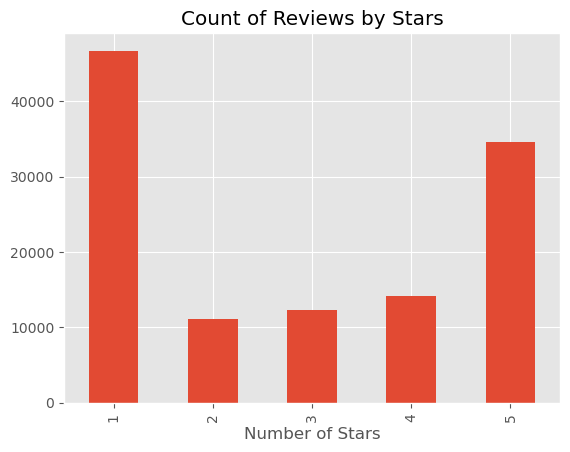

In [60]:
# Count of reviews by rating (stars)
df["score"].value_counts().sort_index().plot(kind="bar", title="Count of Reviews by Stars",xlabel = "Number of Stars")
print(nltk.data.path)

# Basic NLTK example

In [61]:
# Basic NLTK example
example = df["content"][50]
print(example)

# Tokenizing the example review
tokens = nltk.word_tokenize(example)
tokens



No update of new movies and series.


['No', 'update', 'of', 'new', 'movies', 'and', 'series', '.']

In [62]:
# Tagging words according to their type (Part-of-Speech tagging)
tagged = nltk.pos_tag(tokens)
tagged

[('No', 'DT'),
 ('update', 'NN'),
 ('of', 'IN'),
 ('new', 'JJ'),
 ('movies', 'NNS'),
 ('and', 'CC'),
 ('series', 'NN'),
 ('.', '.')]

In [63]:
# Named entity recognition
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()


(S No/DT update/NN of/IN new/JJ movies/NNS and/CC series/NN ./.)


We started using VADER.
Each word has a positive, negative, or neutral association, and by evaluating the set as a whole, it analyzes the sentiment of the sentence."

In [64]:
# Initializing the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [65]:
# Checking polarity scores for sample texts
sia.polarity_scores(df["content"].values[1])

{'neg': 0.073, 'neu': 0.758, 'pos': 0.169, 'compound': 0.765}

In [66]:
# Running the polarity score on the entire dataset
res = {}
for i, row in df.iterrows():
    text = row["content"]
    myid = row["reviewId"]
    res[myid] = sia.polarity_scores(text)



In [67]:
# Converting to dataframe and merging it with the original dataframe by 'reviewId'
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index": "reviewId"})
vaders = vaders.merge(df, how="left")
vaders.head()


,reviewId,neg,neu,pos,compound,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,fad76646-9d91-47d6-ae0e-f34d65722100,0.000,0.000,1.000,0.2960,Usman Pk,Ok,5,0,NaN,2024-11-11 13:16:56,NaN
1,689ea35c-4290-4b6f-ba50-b3f5e883126c,0.073,0.758,0.169,0.7650,Alexander Jiménez,I think this is an amazing app u can watch man...,4,0,8.139.1 build 24 51108,2024-11-11 13:10:12,8.139.1 build 24 51108
2,180f6abf-02d1-4e26-9061-307bff63d93d,0.233,0.584,0.183,-0.1955,Darius Blizzard,"Great app, just can't play Into the dead 2: Un...",4,0,8.139.1 build 24 51108,2024-11-11 13:09:26,8.139.1 build 24 51108
3,b30ae633-ed3b-4ebd-a8b4-4d9ff929f6de,0.000,1.000,0.000,0.0000,Nathan Shotter,Real ii64,5,0,8.139.1 build 24 51108,2024-11-11 13:07:39,8.139.1 build 24 51108
4,9cf63d64-30df-448d-bfa5-58aa8aae8d1c,0.124,0.476,0.400,0.5994,Masego Mnguni,I love Netflix it has serious and movies,5,0,NaN,2024-11-11 13:01:28,NaN


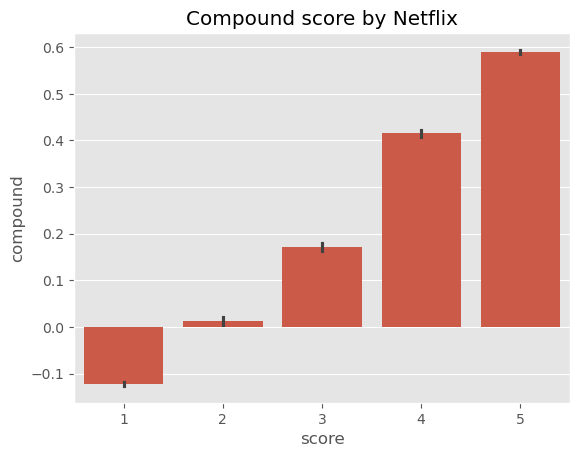

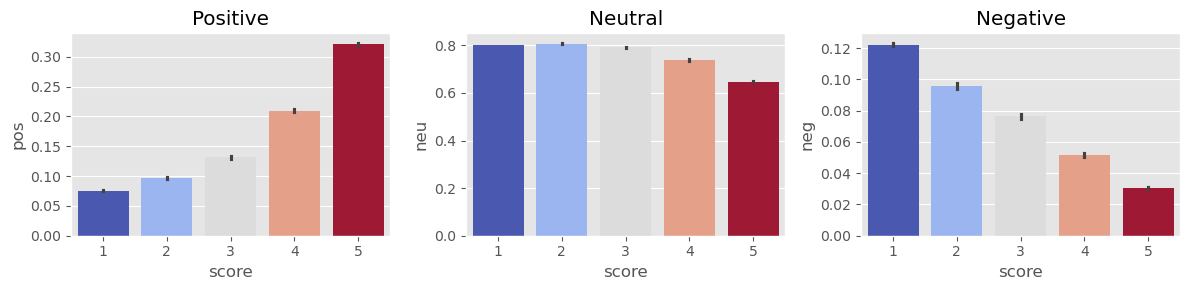

In [68]:
# Plotting VADER results
ax = sns.barplot(data=vaders, x="score", y="compound")
ax.set_title("Compound score by Netflix")
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x="score", y="pos", ax=axs[0], hue = "score", legend=False, palette="coolwarm")
sns.barplot(data=vaders, x="score", y="neu", ax=axs[1], hue = "score", legend=False, palette="coolwarm")
sns.barplot(data=vaders, x="score", y="neg", ax=axs[2], hue = "score", legend=False, palette="coolwarm")
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()


In [69]:

# Filtering negative comments
negative_comments = vaders[vaders['neg'] > 0.5]  # Adjust threshold as needed

# Concatenating negative comments into one text string
negative_texts = ' '.join(negative_comments['content'].dropna())

# Tokenizing the negative text
tokens = word_tokenize(negative_texts.lower())
print(tokens)

# Removing stopwords and punctuation
stop_words = set(stopwords.words('english'))
tokens_clean = [word for word in tokens if word not in stop_words and word not in string.punctuation]

# Generating bigrams (can adjust for n-grams with n > 2)
bigrams = ngrams(tokens_clean, 2)

# Counting the most common bigrams
bigram_fdist = FreqDist(bigrams)

# Showing the 10 most common bigrams
print(bigram_fdist.most_common(10))


['worst', 'always', 'crashing', 'on', 'mobile', 'error', 'platform', 'removed', 'gcash', 'payment', ':', '<', 'very', 'bad', 'app', 'i', 'hate', 'this', 'app', 'so', 'much', 'f', '*', '*', '*', 'worst', 'app', 'it', 'show', 'error', '5.8', 'what', "'s", 'the', 'problem', 'utterly', 'useless', '!', 'download', 'problem', 'no', 'kannada', 'language', 'so', 'disappointed', 'bad', 'scam', 'bc', 'very', 'bad', 'total', 'disaster', 'boycott', 'themmm', 'bad', 'no', 'oky', 'no', 'tamil', 'audio', 'bad', 'it', "'s", 'always', 'lagging', 'bad', 'quality', 'service', 'not', 'worked', 'good', 'absolutely', '💯', '%', 'rubbish', '🗑', 'app', 'avoid', 'not', 'good', 'disgusting', 'third', 'class', 'aap', 'so', 'bad', 'sign', 'in', 'problem', 'became', 'so', 'bad', 'just', 'not', 'worth', '1', 'cent', 'worst', 'app', 'i', 'have', 'ever', 'used', '.', 'bad', 'application', 'bad', 'useless', 'bad', 'app', 'the', 'worst', 'file', 'disturb', 'crash', 'bad', 'worst', 'not', 'special', 'subtitle', 'sinhala'

TEXTBLOB

In [ ]:
# Running TextBlob sentiment analysis
resTextBlob = {}
for i, row in df.iterrows():
    text = row["content"]
    myid = row["reviewId"]
    resTextBlob[myid] = TextBlob(row["content"]).sentiment

In [ ]:
# Converting to dataframe and merging it with the original dataframe by 'reviewId'
Blob = pd.DataFrame(resTextBlob).T
Blob = Blob.reset_index().rename(columns={"index": "reviewId", 0: "polarity", 1: "subjectivity"})
Blob = Blob.merge(df, how="left")
Blob.head()

,reviewId,polarity,subjectivity,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,fad76646-9d91-47d6-ae0e-f34d65722100,0.500000,0.500000,Usman Pk,Ok,5,0,NaN,2024-11-11 13:16:56,NaN
1,689ea35c-4290-4b6f-ba50-b3f5e883126c,0.633333,0.716667,Alexander Jiménez,I think this is an amazing app u can watch man...,4,0,8.139.1 build 24 51108,2024-11-11 13:10:12,8.139.1 build 24 51108
2,180f6abf-02d1-4e26-9061-307bff63d93d,0.066667,0.516667,Darius Blizzard,"Great app, just can't play Into the dead 2: Un...",4,0,8.139.1 build 24 51108,2024-11-11 13:09:26,8.139.1 build 24 51108
3,b30ae633-ed3b-4ebd-a8b4-4d9ff929f6de,0.200000,0.300000,Nathan Shotter,Real ii64,5,0,8.139.1 build 24 51108,2024-11-11 13:07:39,8.139.1 build 24 51108
4,9cf63d64-30df-448d-bfa5-58aa8aae8d1c,0.083333,0.633333,Masego Mnguni,I love Netflix it has serious and movies,5,0,NaN,2024-11-11 13:01:28,NaN


Text(0.5, 1.0, 'Compound score by Netflix')

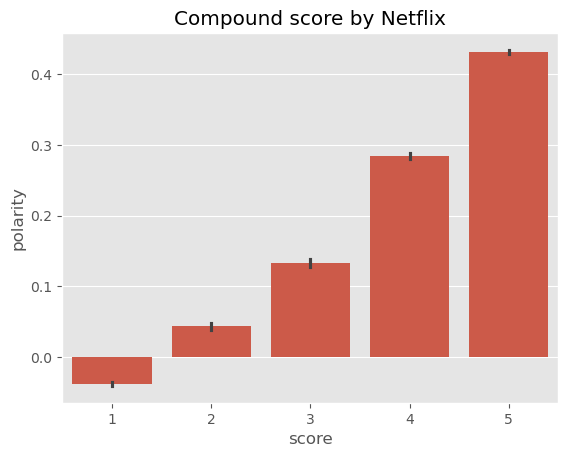

In [ ]:
# Plotting TEXBLOB results
ax = sns.barplot(data=Blob, x="score", y="polarity")
ax.set_title("Compound score by Netflix")